# Imports

In [14]:
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from scipy.stats import uniform, randint
from catboost import CatBoostClassifier
import warnings
import shap

warnings.filterwarnings("ignore")

RANDOM_STATE = 42

In [15]:
TRAIN_PATH = "./db/train_data.csv"
VAL_PATH   = "./db/val_data.csv"
TEST_PATH  = "./db/test_data.csv"
TARGET_COL = "label"
DROP_COLS  = ["patient_id", "date"]

# Datasets

In [16]:
train = pd.read_csv(TRAIN_PATH)
val   = pd.read_csv(VAL_PATH)
test  = pd.read_csv(TEST_PATH)

In [17]:
X_train = train.drop(columns=[TARGET_COL] + [c for c in DROP_COLS if c in train.columns])
y_train = train[TARGET_COL].copy()
X_val   = val.drop(columns=[TARGET_COL] + [c for c in DROP_COLS if c in val.columns])
y_val   = val[TARGET_COL].copy()
X_test  = test.drop(columns=[TARGET_COL] + [c for c in DROP_COLS if c in test.columns])
y_test  = test[TARGET_COL].copy()

# Modelagem

In [18]:
def resample_train(X, y, target_ratio=1.0, random_state=42):
    target_ratio = 2
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
    if not isinstance(y, pd.Series):
        y = pd.Series(y, name=TARGET_COL)

    pos_idx = y[y == 1].index.to_numpy()
    neg_idx = y[y == 0].index.to_numpy()

    n_pos = len(pos_idx)
    n_neg = len(neg_idx)

    if n_pos == 0 or n_neg == 0:
        return X.reset_index(drop=True), y.reset_index(drop=True)

    n_neg_target = int(n_pos * float(target_ratio))

    rng = np.random.RandomState(random_state)


    neg_keep = rng.choice(neg_idx, size=n_neg_target, replace=False)


    extra_needed = n_neg_target - n_pos
    pos_extra = rng.choice(pos_idx, size=extra_needed, replace=True)
    pos_keep = np.concatenate([pos_idx, pos_extra])

#     pos_keep = pos_idx

    keep_idx = np.concatenate([neg_keep, pos_keep])
    rng.shuffle(keep_idx)

    X_res = X.loc[keep_idx].reset_index(drop=True)
    y_res = y.loc[keep_idx].reset_index(drop=True)

    return X_res, y_res

def evaluate(model, X, y, set_name="set"):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    acc = accuracy_score(y, y_pred)
    report = classification_report(y, y_pred, digits=4)
    cm = confusion_matrix(y, y_pred)

    print(f"\n---------------------------------- Avaliação no {set_name} ---------------------------------\n")
    print("Accuracy:", acc)
    print("\nClassification report:\n", report)
    print("Confusion matrix:\n", cm)

    unique_classes = np.unique(y)
    if len(unique_classes) == 2 and y_proba is not None:
        auc = roc_auc_score(y, y_proba)
        print("\nROC AUC:", auc)
        fpr, tpr, thr = roc_curve(y, y_proba)
        plt.figure(figsize=(12, 4))
        plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
        plt.plot([0,1],[0,1],"--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC curve - {set_name}")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    return {"accuracy": acc, "report_str": report, "confusion_matrix": cm}

In [19]:
# ---------- Codificar target se necessário ----------
le = None
if y_train.dtype == object or y_train.dtype.name == "category":
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_val   = le.transform(y_val)
    y_test  = le.transform(y_test)
    joblib.dump(le, os.path.join(RESULTS_DIR, "label_encoder.joblib"))

In [20]:
unique, counts = np.unique(y_train, return_counts=True)
balance_ratio = None
if len(unique) == 2:
    neg = counts[unique.tolist().index(0)]
    pos = counts[unique.tolist().index(1)]
    balance_ratio = neg / pos if pos > 0 else 1.0

In [21]:
catboost_base = CatBoostClassifier(
    iterations=100,            # valor default - será sobrescrito pelo RandomSearch
    learning_rate=0.1,
    depth=6,
    loss_function="Logloss",
    eval_metric="AUC" if len(unique) == 2 else "MultiClass",
    random_seed=RANDOM_STATE,
    thread_count=-1,
    verbose=0
)

In [22]:
param_distributions = {
    "iterations": randint(50, 2000),                    # número de árvores/iterações
    "depth": randint(3, 11),                            # profundidade da árvore
    "learning_rate": uniform(loc=0.001, scale=0.5),     # taxa de aprendizado
    "l2_leaf_reg": uniform(loc=0.0, scale=10.0),        # regularização L2
    "border_count": randint(32, 255),                   # binning (CatBoost)
    "bagging_temperature": uniform(loc=0.0, scale=1.5), # para bagging
    "random_strength": uniform(loc=0.0, scale=2.0),     # força da aleatoriedade
    "rsm": uniform(loc=0.5, scale=0.5),                 # feature subsample (0..1)
}

In [23]:
if balance_ratio is not None:
    param_distributions["scale_pos_weight"] = [1.0, balance_ratio]

cv = TimeSeriesSplit(n_splits=5)
n_iter = 10
X_train_fit = X_train
y_train_fit = y_train

In [24]:
random_search = RandomizedSearchCV(
    estimator=catboost_base,
    param_distributions=param_distributions,
    n_iter=n_iter,
    scoring="accuracy",     # altere para 'roc_auc' se for binário e preferir AUC
    cv=cv,
    verbose=2,
    random_state=RANDOM_STATE,
    n_jobs=1,               # CatBoost é multithread; set n_jobs=1 para evitar oversubscribe
    return_train_score=True
)

# Fit com Dados Reais

In [25]:
random_search.fit(X_train_fit, y_train_fit)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bagging_temperature=0.5618101782710437, border_count=124, depth=9, iterations=1180, l2_leaf_reg=7.796910002727692, learning_rate=0.2994250789732435, random_strength=0.8916655057071823, rsm=0.5499874579090014, scale_pos_weight=1.0; total time=  20.8s
[CV] END bagging_temperature=0.5618101782710437, border_count=124, depth=9, iterations=1180, l2_leaf_reg=7.796910002727692, learning_rate=0.2994250789732435, random_strength=0.8916655057071823, rsm=0.5499874579090014, scale_pos_weight=1.0; total time=  21.1s
[CV] END bagging_temperature=0.5618101782710437, border_count=124, depth=9, iterations=1180, l2_leaf_reg=7.796910002727692, learning_rate=0.2994250789732435, random_strength=0.8916655057071823, rsm=0.5499874579090014, scale_pos_weight=1.0; total time=  23.1s
[CV] END bagging_temperature=0.5618101782710437, border_count=124, depth=9, iterations=1180, l2_leaf_reg=7.796910002727692, learning_rate=0.2994250789732435, rand

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7bf3df763aa0>,
                   n_jobs=1,
                   param_distributions={'bagging_temperature': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bf3df937530>,
                                        'border_count': <scipy.stats._distn_infrastructure.rv_discrete...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bf3df783500>,
                                        'random_strength': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bf3df763b90>,
                                        'rsm': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bf3df77bec0>,
                                        'scale_pos_weight': [1.0,
                                                             np.float64(11.453416149068323)]},
                   random_state=42, return_train_score=True, scoring='accuracy',
                   verbose=2)

In [26]:
best_model = random_search.best_estimator_

print("Melhores parâmetros encontrados:")
print(random_search.best_params_)
print("\nMelhor score CV (scoring chosen):", random_search.best_score_)

Melhores parâmetros encontrados:
{'bagging_temperature': np.float64(0.2727374508106509), 'border_count': 52, 'depth': 3, 'iterations': 509, 'l2_leaf_reg': np.float64(6.116531604882809), 'learning_rate': np.float64(0.004533152609858703), 'random_strength': np.float64(0.046124850082831514), 'rsm': np.float64(0.7623873301291946), 'scale_pos_weight': 1.0}

Melhor score CV (scoring chosen): 0.9113772455089819


# Avaliação com Dados Reais


---------------------------------- Avaliação no validation ---------------------------------

Accuracy: 0.9404761904761905

Classification report:
               precision    recall  f1-score   support

           0     0.9431    0.9968    0.9692       316
           1     0.5000    0.0500    0.0909        20

    accuracy                         0.9405       336
   macro avg     0.7216    0.5234    0.5301       336
weighted avg     0.9167    0.9405    0.9169       336

Confusion matrix:
 [[315   1]
 [ 19   1]]

ROC AUC: 0.8518987341772152


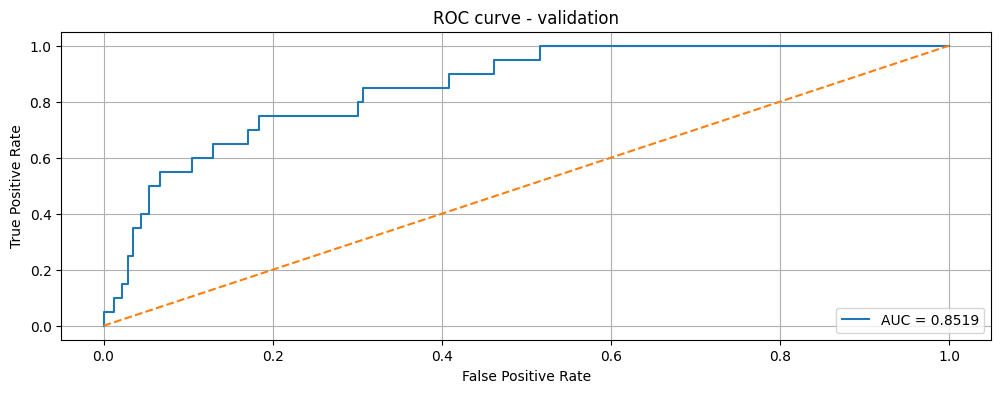


---------------------------------- Avaliação no test ---------------------------------

Accuracy: 0.8505494505494505

Classification report:
               precision    recall  f1-score   support

           0     0.8578    0.9870    0.9179       385
           1     0.5833    0.1000    0.1707        70

    accuracy                         0.8505       455
   macro avg     0.7206    0.5435    0.5443       455
weighted avg     0.8156    0.8505    0.8029       455

Confusion matrix:
 [[380   5]
 [ 63   7]]

ROC AUC: 0.7484230055658627


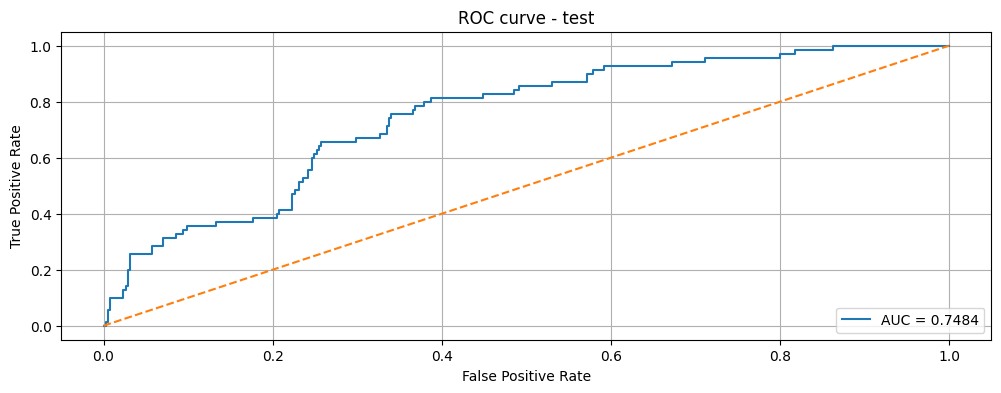

In [27]:
res_val = evaluate(best_model, X_val, y_val, set_name="validation")
res_test = evaluate(best_model, X_test, y_test, set_name="test")

# Fit com Resample

In [28]:
X_train_res, y_train_res = resample_train(X_train, y_train, target_ratio=1.0, random_state=RANDOM_STATE)

random_search.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bagging_temperature=0.5618101782710437, border_count=124, depth=9, iterations=1180, l2_leaf_reg=7.796910002727692, learning_rate=0.2994250789732435, random_strength=0.8916655057071823, rsm=0.5499874579090014, scale_pos_weight=1.0; total time=  14.8s
[CV] END bagging_temperature=0.5618101782710437, border_count=124, depth=9, iterations=1180, l2_leaf_reg=7.796910002727692, learning_rate=0.2994250789732435, random_strength=0.8916655057071823, rsm=0.5499874579090014, scale_pos_weight=1.0; total time=  21.0s
[CV] END bagging_temperature=0.5618101782710437, border_count=124, depth=9, iterations=1180, l2_leaf_reg=7.796910002727692, learning_rate=0.2994250789732435, random_strength=0.8916655057071823, rsm=0.5499874579090014, scale_pos_weight=1.0; total time=  20.6s
[CV] END bagging_temperature=0.5618101782710437, border_count=124, depth=9, iterations=1180, l2_leaf_reg=7.796910002727692, learning_rate=0.2994250789732435, rand

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7bf3df763aa0>,
                   n_jobs=1,
                   param_distributions={'bagging_temperature': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bf3df937530>,
                                        'border_count': <scipy.stats._distn_infrastructure.rv_discrete...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bf3df783500>,
                                        'random_strength': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bf3df763b90>,
                                        'rsm': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bf3df77bec0>,
                                        'scale_pos_weight': [1.0,
                                                             np.float64(11.453416149068323)]},
                   random_state=42, return_train_score=True, scoring='accuracy',
                   verbose=2)

In [29]:
best_model_res = random_search.best_estimator_

print("Melhores parâmetros encontrados:")
print(random_search.best_params_)
print("\nMelhor score CV (scoring chosen):", random_search.best_score_)

Melhores parâmetros encontrados:
{'bagging_temperature': np.float64(0.5618101782710437), 'border_count': 124, 'depth': 9, 'iterations': 1180, 'l2_leaf_reg': np.float64(7.796910002727692), 'learning_rate': np.float64(0.2994250789732435), 'random_strength': np.float64(0.8916655057071823), 'rsm': np.float64(0.5499874579090014), 'scale_pos_weight': 1.0}

Melhor score CV (scoring chosen): 0.8635514018691589


# Avaliação com Resample


---------------------------------- Avaliação no validation ---------------------------------

Accuracy: 0.8869047619047619

Classification report:
               precision    recall  f1-score   support

           0     0.9633    0.9146    0.9383       316
           1     0.2500    0.4500    0.3214        20

    accuracy                         0.8869       336
   macro avg     0.6067    0.6823    0.6299       336
weighted avg     0.9209    0.8869    0.9016       336

Confusion matrix:
 [[289  27]
 [ 11   9]]

ROC AUC: 0.8329113924050633


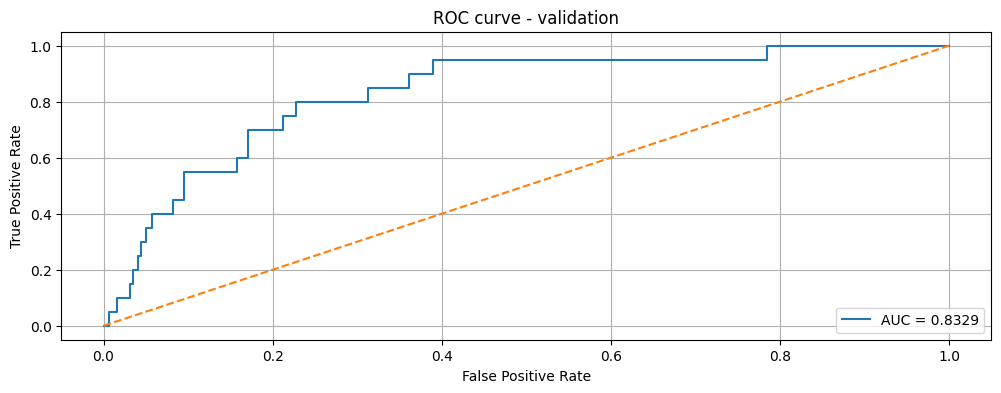


---------------------------------- Avaliação no test ---------------------------------

Accuracy: 0.7472527472527473

Classification report:
               precision    recall  f1-score   support

           0     0.8668    0.8286    0.8473       385
           1     0.2414    0.3000    0.2675        70

    accuracy                         0.7473       455
   macro avg     0.5541    0.5643    0.5574       455
weighted avg     0.7706    0.7473    0.7581       455

Confusion matrix:
 [[319  66]
 [ 49  21]]

ROC AUC: 0.699443413729128


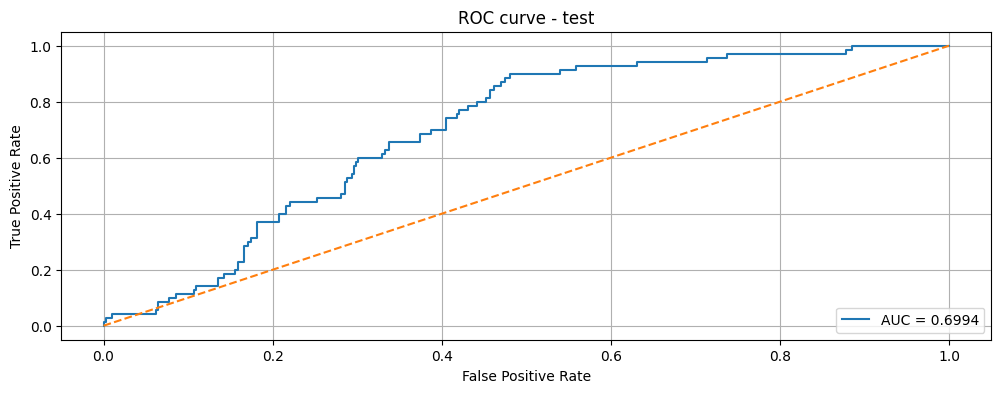

In [30]:
res_val = evaluate(best_model_res, X_val, y_val, set_name="validation")
res_test = evaluate(best_model_res, X_test, y_test, set_name="test")